In [1]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import sys
sys.path.insert(0, '../functions/')
import interface_GAMS as iG
import pickle
from adjustText import adjust_text

pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}

flags_df = pd.read_csv('../data/saved_flags_expanded_curated.csv', index_col = 0)

# plot one example

In [128]:
# settings
case = 'nan___Purine'
mean_min_max = 'max' # the current model only allows one binding site for TF-gene, sometimes multiple binding sites exist, which score do you take?

bye


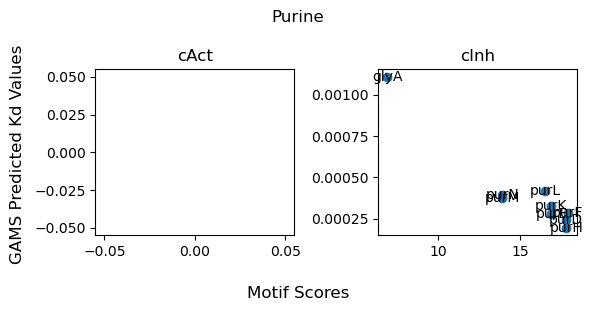

In [136]:
# plotting

# load in TF_flags dataframe
TF_flags_df = pd.read_csv('../data/TF_saved_flags_expanded.csv', index_col = 0)
true_false = []
for iM in TF_flags_df.index:
    if iM in case:
        true_false.append(True)
    else:
        true_false.append(False)
TF_flags_df = TF_flags_df.loc[true_false]


# let's find our run_dir
iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f


if True:
    # first load in relevant info
    mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    pickle_in = open('../data/gene_to_operon_to_motif_scores_dist_to_TSS.pkl', 'rb')
    gene_to_operon_to_motif_scores = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open('../data/b_to_gene.pkl', 'rb')
    b_to_gene = pickle.load(pickle_in)
    pickle_in.close()
    gene_to_b = {v : k for k, v in b_to_gene.items()}
    gene_to_b.update({
        'yhbC' : 'b3170',
        #'sroD' : '', # not a real gene
    })
    # create operon to genes
    f = open('../data/regulonDB_files/OperonSet.txt', 'r')
    lines = f.readlines()
    f.close()
    operon_to_genes = {}
    for line in lines[38:]:
        operon = line.split('\t')[0]
        genes = line.split('\t')[5].split(',')
        operon_to_genes.update({operon : genes})
    operon_to_genes.update({
        'metY-yhbC-nusA-infB-rbfA-truB-rpsO-pnp' : ['metY', 'yhbC', 'nusA', 'infB', 'rbfA', 'truB', 'rpsO', 'pnp'],
        'metY' : ['metY'],
        'hisJQMP' : ['hisJ', 'hisQ', 'hisM', 'hisP'],
        'fabHDG' : ['fabH', 'fabD', 'fabG'],
        'glnB' : ['glnB'],
        'prs' : ['prs'],
    })

    # organize this by regulator to gene to motif scores
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)
    reg_to_gene_to_scores = {}
    for index0, row in TF_flags_df.iterrows():
        GAMS_genes = cAct_mapping.index[cAct_mapping[index0] != 0].to_list() + cInh_mapping.index[cInh_mapping[index0] != 0].to_list()

        reg = row['TF']
        reg_to_gene_to_scores.update({reg : {}})
        if row['TF'][0].upper()+row['TF'][1:] not in gene_to_operon_to_motif_scores:
            continue
        for operon, motif_scores in gene_to_operon_to_motif_scores[row['TF'][0].upper()+row['TF'][1:]].items():
            if operon not in operon_to_genes:
                continue
            genes = operon_to_genes[operon]
            for gene in genes:
                if gene not in gene_to_b and gene not in ['sroD']:
                    print(gene)
                    continue
                if gene in ['sroD']:
                    continue
                b_gene = gene_to_b[gene]
                if b_gene not in reg_to_gene_to_scores[reg]:
                    reg_to_gene_to_scores[reg].update({b_gene : []})
                for score in motif_scores:
                    reg_to_gene_to_scores[reg][b_gene].append(score)
        # let's look at cAct kd's
        bby_cAct_kd_df = cAct_kd_df.loc[cAct_mapping.index[cAct_mapping[index0] != 0].to_list()]
        bby_cAct_kd_df = bby_cAct_kd_df[bby_cAct_kd_df['iM'] == index0][['Val']]
        scores = []
        keep = []
        labels1 = []
        for index in bby_cAct_kd_df.index:
            try:
                if mean_min_max == 'mean':
                    to_add = np.mean([val[0] for val in reg_to_gene_to_scores[reg][index]])
                elif mean_min_max == 'min':
                    to_add = np.min([val[0] for val in reg_to_gene_to_scores[reg][index]])
                elif mean_min_max == 'max':
                    to_add = np.max([val[0] for val in reg_to_gene_to_scores[reg][index]])
                scores.append(to_add)
                keep.append(index)
                labels1.append(b_to_gene[index])
            except:
                pass
        bby_cAct_kd_df = bby_cAct_kd_df.loc[keep]
        bby_cAct_kd_df['motif_scores'] = scores

        # let's look at cInh kd's
        bby_cInh_kd_df = cInh_kd_df.loc[cInh_mapping.index[cInh_mapping[index0] != 0].to_list()]
        bby_cInh_kd_df = bby_cInh_kd_df[bby_cInh_kd_df['iM'] == index0][['Val']]
        scores = []
        keep = []
        labels2 = []
        for index in bby_cInh_kd_df.index:
            if index in ['b1131']:
                continue
            try:
                if mean_min_max == 'mean':
                    to_add = np.mean([val[0] for val in reg_to_gene_to_scores[reg][index]])
                elif mean_min_max == 'min':
                    to_add = np.min([val[0] for val in reg_to_gene_to_scores[reg][index]])
                elif mean_min_max == 'max':
                    to_add = np.max([val[0] for val in reg_to_gene_to_scores[reg][index]])
                scores.append(to_add)
                keep.append(index)
                labels2.append(b_to_gene[index])
            except:
                pass
        bby_cInh_kd_df = bby_cInh_kd_df.loc[keep]
        bby_cInh_kd_df['motif_scores'] = scores

        # plotting
        fig, axs = plt.subplots(1, 2, figsize = (6, 3))
        x = bby_cAct_kd_df['motif_scores']
        y = bby_cAct_kd_df['Val']
        axs[0].scatter(x, y)
        texts1 = [axs[0].text(x[i], y[i], labels1[i], ha='center', va='center') for i in range(len(x))]
        #adjust_text(texts1, arrowprops=dict(arrowstyle='-', color='k'))
        x = bby_cInh_kd_df['motif_scores']
        y = bby_cInh_kd_df['Val']
        axs[1].scatter(x, y)
        texts2 = [axs[1].text(x[i], y[i], labels2[i], ha='center', va='center') for i in range(len(x))]
        #adjust_text(texts2, arrowprops=dict(arrowstyle='-', color='k'))
        axs[0].set_title('cAct')
        axs[1].set_title('cInh')
        fig.supxlabel('Motif Scores')
        fig.supylabel('GAMS Predicted Kd Values')
        fig.suptitle(index0)
        plt.tight_layout()
        plt.savefig('../figures/GAMS_kd_vs_motif_'+index0+'.pdf', transparent = True)
        plt.show()

# let's conglomerate them all together and make a model-wide motif vs promoter prediction

In [150]:
# settings
mean_min_max = 'max' # the current model only allows one binding site for TF-gene, sometimes multiple binding sites exist, which score do you take?
filter_dist = (-60, 60) # dist to TSS from reported, only consider options in this range

In [151]:
# first, create the dataframes



# load in necessary files
base_TF_flags_df = pd.read_csv('../data/TF_saved_flags_expanded.csv', index_col = 0)
pickle_in = open('../data/gene_to_operon_to_motif_scores_dist_to_TSS.pkl', 'rb')
gene_to_operon_to_motif_scores = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('../data/b_to_gene.pkl', 'rb')
b_to_gene = pickle.load(pickle_in)
pickle_in.close()
gene_to_b = {v : k for k, v in b_to_gene.items()}
gene_to_b.update({
    'yhbC' : 'b3170',
    #'sroD' : '', # not a real gene
})
# create operon to genes
f = open('../data/regulonDB_files/OperonSet.txt', 'r')
lines = f.readlines()
f.close()
operon_to_genes = {}
for line in lines[38:]:
    operon = line.split('\t')[0]
    genes = line.split('\t')[5].split(',')
    operon_to_genes.update({operon : genes})
operon_to_genes.update({
    'metY-yhbC-nusA-infB-rbfA-truB-rpsO-pnp' : ['metY', 'yhbC', 'nusA', 'infB', 'rbfA', 'truB', 'rpsO', 'pnp'],
    'metY' : ['metY'],
    'hisJQMP' : ['hisJ', 'hisQ', 'hisM', 'hisP'],
    'fabHDG' : ['fabH', 'fabD', 'fabG'],
    'glnB' : ['glnB'],
    'prs' : ['prs'],
})

act_cases = []
act_genes = []
act_TF_kds = []
act_motif_scores = []
act_dist_to_TSS = []
inh_cases = []
inh_genes = []
inh_TF_kds = []
inh_motif_scores = []
inh_dist_to_TSS = []
for iMs_run in set([(row['act_iM'], row['inh_iM']) for _, row in flags_df.iterrows()]):
    clean = [x for x in iMs_run if str(x) != 'nan']
    case = '___'.join([str(iM) for iM in iMs_run]).replace(' ', '_').replace('/', '_')
    
    # parse down TF_flags
    true_false = []
    for iM in base_TF_flags_df.index:
        if iM in iMs_run:
            true_false.append(True)
        else:
            true_false.append(False)
    TF_flags_df = base_TF_flags_df.loc[true_false]

    # let's find our run_dir
    try:
        iter_f = 'iter_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case) if 'iter_' in f and '.pkl' not in f]))
        run_f = 'run_'+str(max([int(f.split('_')[1]) for f in os.listdir('../GAMs/optimization_runs/'+case+'/'+iter_f) if 'run_' in f and '.pkl' not in f]))
        GAMs_run_dir = '../GAMs/optimization_runs/'+case+'/'+iter_f+'/'+run_f
    except:
        print(case+' : cannot find saved_run, skipping')
        continue
    print(case+' : processing...')
    
    # load in results and dictionaries
    try:
        mRNA_df, GAMS_calc_cAct, cAct_kd_df, act_metab_df, act_kd_metab_df, GAMS_calc_cInh, cInh_kd_df, inh_metab_df, inh_kd_metab_df = iG.read_multi_GAMs(GAMs_run_dir)
    except:
        print('\t issue loading in GAMS results, continuing')
        continue

    # organize this by regulator to gene to motif scores
    cAct_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cAct_mapping.csv', index_col = 0)
    cInh_mapping = pd.read_csv(GAMs_run_dir+'/input_files/cInh_mapping.csv', index_col = 0)
    reg_to_gene_to_scores = {}
    for index0, row in TF_flags_df.iterrows():
        GAMS_genes = cAct_mapping.index[cAct_mapping[index0] != 0].to_list() + cInh_mapping.index[cInh_mapping[index0] != 0].to_list()

        reg = row['TF']
        reg_to_gene_to_scores.update({reg : {}})
        if row['TF'][0].upper()+row['TF'][1:] not in gene_to_operon_to_motif_scores:
            print('\t'+row['gene_name']+' not found in motif search, continue with others')
            continue
        for operon, motif_scores in gene_to_operon_to_motif_scores[row['TF'][0].upper()+row['TF'][1:]].items():
            if operon not in operon_to_genes:
                continue
            genes = operon_to_genes[operon]
            for gene in genes:
                if gene not in gene_to_b and gene not in ['sroD']:
                    print(gene)
                    continue
                if gene in ['sroD']:
                    continue
                b_gene = gene_to_b[gene]
                if b_gene not in reg_to_gene_to_scores[reg]:
                    reg_to_gene_to_scores[reg].update({b_gene : []})
                for score in motif_scores:
                    reg_to_gene_to_scores[reg][b_gene].append(score)

        # let's look at cAct kd's
        bby_cAct_kd_df = cAct_kd_df.loc[cAct_mapping.index[cAct_mapping[index0] != 0].to_list()]
        bby_cAct_kd_df = bby_cAct_kd_df[bby_cAct_kd_df['iM'] == index0][['Val']]
        scores = []
        dists = []
        keep = []
        labels1 = []
        for index in bby_cAct_kd_df.index:
            try:
                # filter based on dist to TSS
                filtered_vals = [val[0] for val in reg_to_gene_to_scores[reg][index] if val[1] < filter_dist[1] and val[1] > filter_dist[0]]
                if mean_min_max == 'mean':
                    to_add = np.max(filtered_vals)
                elif mean_min_max == 'min':
                    to_add = np.max(filtered_vals)
                elif mean_min_max == 'max':
                    to_add = np.max(filtered_vals)
                dist = [val[1] for val in reg_to_gene_to_scores[reg][index] if val[0] == to_add]
                dists.append(dist)
                scores.append(to_add)
                keep.append(index)
                labels1.append(b_to_gene[index])
            except:
                pass
        bby_cAct_kd_df = bby_cAct_kd_df.loc[keep]
        bby_cAct_kd_df['motif_scores'] = scores
        bby_cAct_kd_df['dist_to_TSS'] = dists

        # let's look at cInh kd's
        bby_cInh_kd_df = cInh_kd_df.loc[cInh_mapping.index[cInh_mapping[index0] != 0].to_list()]
        bby_cInh_kd_df = bby_cInh_kd_df[bby_cInh_kd_df['iM'] == index0][['Val']]
        scores = []
        dists = []
        keep = []
        labels2 = []
        for index in bby_cInh_kd_df.index:
            if index in ['b1131']:
                continue
            try:
                # filter based on dist to TSS
                filtered_vals = [val[0] for val in reg_to_gene_to_scores[reg][index] if val[1] < filter_dist[1] and val[1] > filter_dist[0]]
                if mean_min_max == 'mean':
                    to_add = np.max(filtered_vals)
                elif mean_min_max == 'min':
                    to_add = np.max(filtered_vals)
                elif mean_min_max == 'max':
                    to_add = np.max(filtered_vals)
                dist = [val[1] for val in reg_to_gene_to_scores[reg][index] if val[0] == to_add]
                dists.append(dist)
                scores.append(to_add)
                keep.append(index)
                labels2.append(b_to_gene[index])
            except:
                pass
        bby_cInh_kd_df = bby_cInh_kd_df.loc[keep]
        bby_cInh_kd_df['motif_scores'] = scores
        bby_cInh_kd_df['dist_to_TSS'] = dists
        
        # save off
        for index, row in bby_cAct_kd_df.iterrows():
            act_cases.append(case)
            act_genes.append(index)
            act_TF_kds.append(row['Val'])
            act_motif_scores.append(row['motif_scores'])
            act_dist_to_TSS.append(row['dist_to_TSS'])
        for index, row in bby_cInh_kd_df.iterrows():
            inh_cases.append(case)
            inh_genes.append(index)
            inh_TF_kds.append(row['Val'])
            inh_motif_scores.append(row['motif_scores'])
            inh_dist_to_TSS.append(row['dist_to_TSS'])

# merge to dataframe
merged_act = pd.DataFrame(index = act_genes)
merged_act['case'] = act_cases
merged_act['TF_kd'] = act_TF_kds
merged_act['motif_scores'] = act_motif_scores
merged_act['dist_to_TSS'] = act_dist_to_TSS
merged_inh = pd.DataFrame(index = inh_genes)
merged_inh['case'] = inh_cases
merged_inh['TF_kd'] = inh_TF_kds
merged_inh['motif_scores'] = inh_motif_scores
merged_inh['dist_to_TSS'] = inh_dist_to_TSS

Lrp___nan : processing...
DNA_Damage___nan : cannot find saved_run, skipping
Nitrogen___nan : processing...
nan___Lrp : processing...
nan___ArcA : processing...
nan___Arginine : processing...
nan___Purine : processing...
Potassium___nan : cannot find saved_run, skipping
nan___Cysteine-1 : processing...
CpxR___nan : processing...
Fur-2___nan : processing...
BasR___nan : processing...
FlhDC-2___nan : processing...
	 issue loading in GAMS results, continuing
Phosphate-1___nan : processing...
nan___Fur-1 : processing...
FlhDC-2___FlhDC-1 : processing...
	b1892 not found in motif search, continue with others
Biotin___nan : processing...
	b3973 not found in motif search, continue with others
nan___Nitrogen : processing...
YcjW___nan : processing...
	b1320 not found in motif search, continue with others
Capsule___nan : processing...
	b1951 not found in motif search, continue with others
SoxS___nan : processing...
Pyruvate-1___nan : processing...
	b2125 not found in motif search, continue with

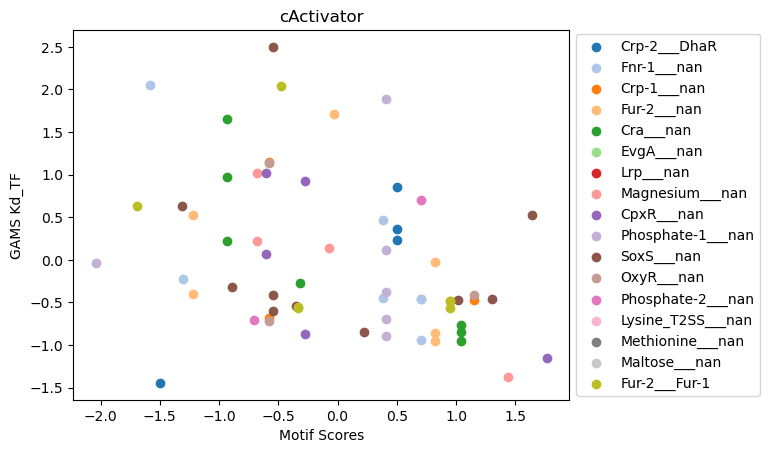

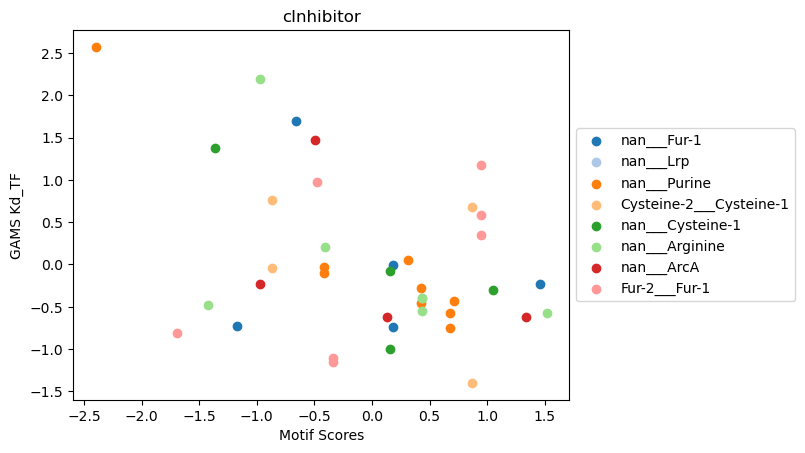

In [153]:
# plotting
colors = list(cm.tab20.colors)
markers = ['o', 'x']
limit_samples = []#'nan___Purine']

mark_col = it.product(markers, colors)
plt.figure()
for case in set(merged_act.case):
    if len(limit_samples) > 0 and case not in limit_samples:
        continue
    bby = merged_act[merged_act['case'] == case]
    if len(bby) == 0:
        continue
    bby.loc[:, 'motif_scores'] = (bby['motif_scores'] - bby['motif_scores'].mean()) / bby['motif_scores'].std()
    bby.loc[:, 'TF_kd'] = (bby['TF_kd'] - bby['TF_kd'].mean()) / bby['TF_kd'].std()
    mark, col = next(mark_col)
    plt.scatter(bby['motif_scores'], bby['TF_kd'], color = col, marker = mark, label = case)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Motif Scores')
plt.ylabel('GAMS Kd_TF')
plt.title('cActivator')
plt.show()

mark_col = it.product(markers, colors)
plt.figure()
for case in set(merged_inh.case):
    if len(limit_samples) > 0 and case not in limit_samples:
        continue
    bby = merged_inh[merged_inh['case'] == case]
    if len(bby) == 0:
        continue
    bby.loc[:, 'motif_scores'] = (bby['motif_scores'] - bby['motif_scores'].mean()) / bby['motif_scores'].std()
    bby.loc[:, 'TF_kd'] = (bby['TF_kd'] - bby['TF_kd'].mean()) / bby['TF_kd'].std()
    mark, col = next(mark_col)
    plt.scatter(bby['motif_scores'], bby['TF_kd'], color = col, marker = mark, label = case)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Motif Scores')
plt.ylabel('GAMS Kd_TF')
plt.title('cInhibitor')
plt.show()